## Preparing data

In [1]:
import numpy as np
from scipy import stats

np.random.seed(42)

n_users = 1000
n_avg_view = 1000
mu1, nu1 = 0.050, 5
mu2, nu2 = 0.050, 5

n1 = stats.poisson.rvs(n_avg_view, size=n_users)
r1 = stats.betabinom.rvs(n1, a=nu1 * mu1, b=nu1 * (1 - mu1))

n2 = stats.poisson.rvs(n_avg_view, size=n_users)
r2 = stats.betabinom.rvs(n2, a=nu2 * mu2, b=nu2 * (1 - mu2))

In [2]:
import pandas as pd

control = pd.DataFrame({"user_id": range(n_users), 'click': r1, 'view': n1})
treatment = pd.DataFrame({"user_id": range(n_users, n_users*2), 'click': r2, 'view': n2})

control["ctr"] = control["click"] / control["view"]
treatment["ctr"] = treatment["click"] / treatment["view"]

## Bayesian Binomial Testing

In [3]:
from t_ab.bayesian.binomial import BinomialData, BinomialTest

a = BinomialData("A", control["view"].sum(), control["click"].sum())
b = BinomialData("B", treatment["view"].sum(), treatment["click"].sum())
btest = BinomialTest(a, b)

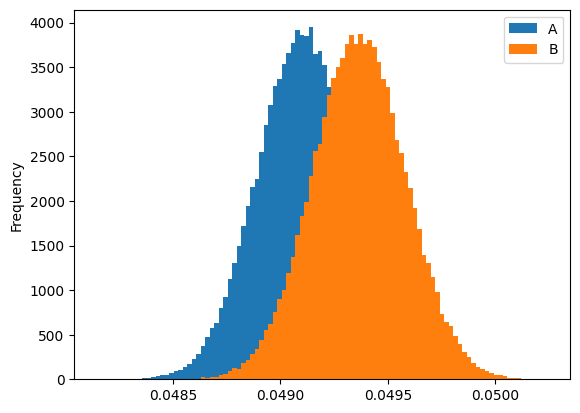

In [4]:
btest.sample().hist()

In [5]:
btest.probs

{'A': 0.19881, 'B': 0.80119}

## Beta-Binomial Modeling

Ref: https://gist.github.com/tnakae/b92fbad3235bbef082c6f3a5b8345d3e

In [6]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist


def beta_binomial_model(n: np.ndarray, r: np.ndarray) -> None:
    """ Beta-Binomialモデル

    user i (=1, .., I) が実験した数 n_i と成功した数 r_i が所与の時の
    Beta-Binomial モデルを表す (mu が確率 p_i の平均となる)

       mu ~ Uniform(0, 1)
       nu ~ Uniform(0.01, 100)
      p_i ~ Beta(nu*mu, nu*(1-mu))
      r_i ~ Binom(n_i, p_i)


    n : 実験数 (n_1, n_2, ..., n_I)
    r : 成功数 (r_1, r_2, ..., r_I)
    """
    # jax array に変換する
    jn = jnp.asarray(n)
    jr = jnp.asarray(r)

    # Beta分布の母数をサンプリング
    mu = numpyro.sample("mu", dist.Uniform(0, 1))
    nu = numpyro.sample("nu", dist.Uniform(0.01, 100))    
    alpha = nu * mu
    beta = nu * (1 - mu)

    # Beta Binomial 分布を表す関数が numpyro に実装されているので
    # これを直接用いる
    numpyro.sample("r", dist.BetaBinomial(alpha, beta, n), obs=r)

In [7]:
kernel = numpyro.infer.NUTS(beta_binomial_model)

In [8]:
mcmc_1 = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
mcmc_1.run(jax.random.PRNGKey(1), n=n1, r=r1)
samples_mu1 = mcmc_1.get_samples()['mu']

sample: 100%|██████████| 11000/11000 [00:16<00:00, 679.12it/s, 5 steps of size 5.38e-01. acc. prob=0.92] 


In [9]:
mcmc_2 = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=1)
mcmc_2.run(jax.random.PRNGKey(1), n=n2, r=r2)
samples_mu2 = mcmc_2.get_samples()['mu']

sample: 100%|██████████| 11000/11000 [00:16<00:00, 659.99it/s, 5 steps of size 4.86e-01. acc. prob=0.94] 


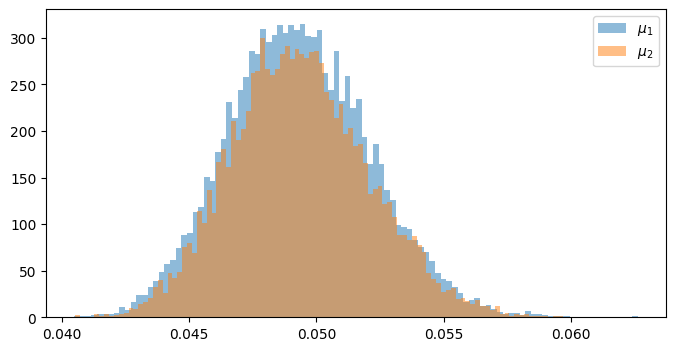

In [10]:

fig, ax = plt.subplots(figsize=[8, 4])

_ = ax.hist(samples_mu1, bins=100, alpha=0.5)
_ = ax.hist(samples_mu2, bins=100, alpha=0.5)

ax.legend(['$\mu_1$', '$\mu_2$'])

In [11]:
# Group1 より Group2 で 1となる確率が高い事後確率
float(np.mean((samples_mu2 - samples_mu1) >= 0))

0.505299985408783

## T-testing for Impression-based metrics with delta method and User-based metrics

In [12]:
from t_ab.frequentist.ctr import ImpressionBasedCTRTtest, UserBasedCTRTtest

ibtest = ImpressionBasedCTRTtest("user_id", "view", "click")
ubtest = UserBasedCTRTtest("user_id", "view", "click")

In [13]:
ibtest(control, treatment)

CTRTestResult(statistics=(Statistics(mean=0.04910526046950915, std=0.08975778518790878, nobs=1000), Statistics(mean=0.049366028899331865, std=0.08427842537945608, nobs=1000)), ttest_result=TtestResult(statistic=-0.06697539014199401, pvalue=0.9466079960614774, is_rejected=False))

In [14]:
ubtest(control, treatment)

CTRTestResult(statistics=(Statistics(mean=0.04915793457087248, std=0.08973791737250772, nobs=1000), Statistics(mean=0.04950717055096145, std=0.08459566999025234, nobs=1000)), ttest_result=TtestResult(statistic=-0.08954968547356125, pvalue=0.928654044154603, is_rejected=False))